In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import torch 
import torch.nn as nn    
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
torch.manual_seed(0)
np.random.seed(0)
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
## season 2 dataframes 
train_x_2 = pd.read_csv('./drive/MyDrive/bitTrader2/train_x_df.csv')
train_y_2 = pd.read_csv('./drive/MyDrive/bitTrader2/train_y_df.csv') 
test_x_2 = pd.read_csv('./drive/MyDrive/bitTrader2/test_x_df.csv') 
submission = pd.read_csv('./drive/MyDrive/bitTrader2/sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape

((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [5]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape

((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [6]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [7]:
def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [8]:
y_train_close = y_train[:,:,4]
x_train_close = x_train[:,:,4].reshape((-1,1380)) 
x_test_close = x_test[:,:,4].reshape((-1,1380))

close_prices = np.concatenate([x_train_close, y_train_close], axis = 1)
close_prices.shape


(7661, 1500)

# Generate Close Price MAs

In [9]:
def ma_smoothing(window, idx, seq_len = 1500): 
  ma_arr = [] 
  for i in range(window,seq_len):
    ma = np.mean(close_prices[idx, i-window:i]) 
    ma_arr.append(ma)  
  ma_arr = np.asarray(ma_arr) 
  return ma_arr 

def ma_smoothing_test(window, idx, seq_len = 1380): 
  ma_arr = [] 
  for i in range(window, seq_len):  
    ma = np.mean(x_test_close[idx, i-window:i]) 
    ma_arr.append(ma) 
  ma_arr = np.asarray(ma_arr) 
  return ma_arr 


In [10]:
X_20 = [] 
for i in tqdm(range(close_prices.shape[0]), position = 0, leave = True): 
  ma_20 = ma_smoothing(20, i) 
  X_20.append(ma_20)  

X_20 = np.asarray(X_20)

100%|██████████| 7661/7661 [01:23<00:00, 91.38it/s]


In [11]:
X_20.shape

(7661, 1480)

In [12]:
K = 120 
N = 60 # get 60 minute data 
seq_len = 1480 # sequence length of 20 day ma   
X = [] 
Y = [] 

for j in tqdm(range(X_20.shape[0]), position = 0, leave = True):   
    i = 0
    while i+N+K < seq_len: 
        X.append(X_20[j, i:i+N]) 
        Y.append(X_20[j, i+N+K]) 
        i += 1 

X = np.asarray(X) 
Y = np.asarray(Y) 

X.shape, Y.shape

100%|██████████| 7661/7661 [00:10<00:00, 715.32it/s]


((9959300, 60), (9959300,))

In [13]:
X = X.reshape((-1,N,1)) 
X.shape

(9959300, 60, 1)

In [17]:
## build model 
def build_model(): 
    inputs = Input((N,1)) # (batch_size, timesteps, features)
    bn = BatchNormalization()(inputs)
    gru = GRU(128, return_sequences = True)(bn)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = True)(gru)  
    gru = Dropout(0.2)(gru) 
    gru = GRU(128, return_sequences = False)(gru)  
    dense = Dense(64, activation = 'relu', kernel_initializer = 'he_normal')(gru) 
    dense = BatchNormalization()(dense) 
    outputs = Dense(1, activation = 'relu')(dense) 
    model = Model(inputs=inputs, outputs = outputs) 
    model.compile(loss='mape', optimizer = 'adam', metrics = ['mae', 'mse'])
    return model 

In [18]:
model = build_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 1)             4         
_________________________________________________________________
gru_3 (GRU)                  (None, 60, 128)           50304     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               9907

In [19]:

model_path = './drive/MyDrive/bitTrader2/GRU_20MA_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit(X,  
                   Y, 
                   batch_size = 32, ## avoid OOM 
                   epochs = 20, 
                   callbacks = [learning_rate_reduction, checkpoint], 
                   validation_split = 0.1)


Epoch 1/20
280106/280106 [==============================] - 3744s 13ms/step - loss: 1.6330 - mae: 0.0164 - mse: 0.0023 - val_loss: 7.0860 - val_mae: 0.0711 - val_mse: 0.0057

Epoch 00001: val_loss improved from inf to 7.08598, saving model to ./drive/MyDrive/bitTrader2/GRU_20MA_epoch_001_val_7.086.h5
Epoch 2/20
280106/280106 [==============================] - 3681s 13ms/step - loss: 1.1632 - mae: 0.0117 - mse: 3.2342e-04 - val_loss: 1.0577 - val_mae: 0.0104 - val_mse: 0.0014

Epoch 00002: val_loss improved from 7.08598 to 1.05770, saving model to ./drive/MyDrive/bitTrader2/GRU_20MA_epoch_002_val_1.058.h5
Epoch 3/20
280106/280106 [==============================] - 3777s 13ms/step - loss: 1.1152 - mae: 0.0112 - mse: 3.0136e-04 - val_loss: 1.1986 - val_mae: 0.0120 - val_mse: 5.5311e-04

Epoch 00003: val_loss did not improve from 1.05770
Epoch 4/20
280106/280106 [==============================] - 3695s 13ms/step - loss: 1.1277 - mae: 0.0113 - mse: 3.0921e-04 - val_loss: 0.9726 - val_mae: 0

KeyboardInterrupt: ignored

# Make Prediction

In [21]:
best_gru = load_model('./drive/MyDrive/bitTrader2/GRU_20MA_epoch_004_val_0.973.h5')

In [22]:
best_gru.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 1)             4         
_________________________________________________________________
gru_3 (GRU)                  (None, 60, 128)           50304     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_4 (GRU)                  (None, 60, 128)           99072     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 128)           0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               9907

In [24]:
X_test_20 = [] 
for i in tqdm(range(x_test_close.shape[0]), position = 0, leave = True): 
  ma_20 = ma_smoothing_test(20, i) 
  X_test_20.append(ma_20)  

X_test_20 = np.asarray(X_test_20)

100%|██████████| 535/535 [00:05<00:00, 104.75it/s]


In [25]:
X_test_20.shape

(535, 1360)

In [26]:
X_test = [] 
for j in tqdm(range(X_test_20.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test.append(X_test_20[j, i:i+N])  

X_test = np.asarray(X_test).reshape((-1,N,1))


100%|██████████| 535/535 [00:00<00:00, 16043.25it/s]


In [27]:
predicted = best_gru.predict(X_test) 
predicted = predicted.reshape((-1,120)) 
predicted.shape


(535, 120)

In [29]:
## create submission dataframe version 1 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('./drive/MyDrive/bitTrader2/gru_conventional.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 4189.57it/s]


In [30]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.308333,107
1,7662,0.583333,48
2,7663,0.141667,94
3,7664,0.950000,24
4,7665,0.000000,114
...,...,...,...
530,8191,0.900000,0
531,8192,0.541667,0
532,8193,0.116667,84
533,8194,0.566667,2


In [31]:
## create submission dataframe version 2 
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_close[i,-1] 
    cnt = 0 
    for j in range(1, 120): 
        if j == 1: 
            returns = predicted[i,j] - buy_price 
        else: 
            returns = predicted[i,j] - predicted[i,j-1]
        if returns >= 0:    
            cnt += 1 
    buy_quantity = cnt/119 # there can be 119 returns only 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('./drive/MyDrive/bitTrader2/gru_non_conventional.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 3326.05it/s]


In [32]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.596639,107
1,7662,0.554622,48
2,7663,0.689076,94
3,7664,0.327731,24
4,7665,0.403361,114
...,...,...,...
530,8191,0.243697,0
531,8192,0.436975,0
532,8193,0.605042,84
533,8194,0.277311,2


# Visualize

In [34]:
predicted_train = best_gru.predict(X[:2400,])
predicted_train = predicted_train.reshape((-1,120))

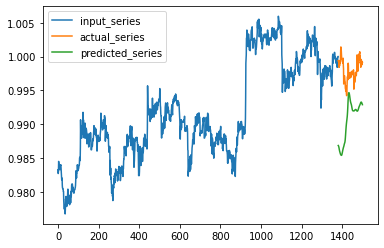

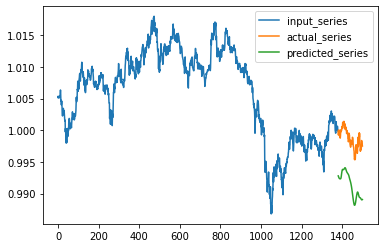

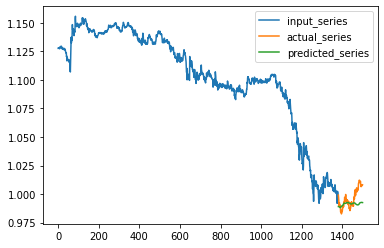

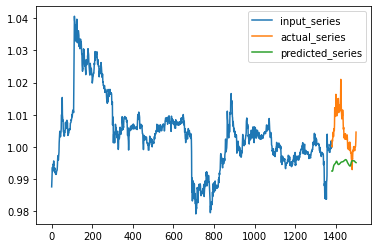

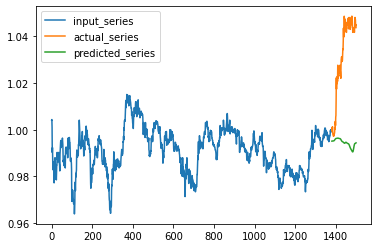

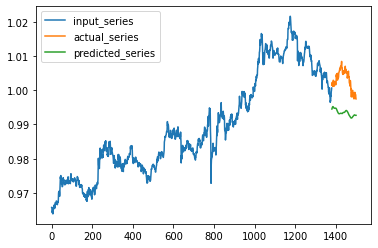

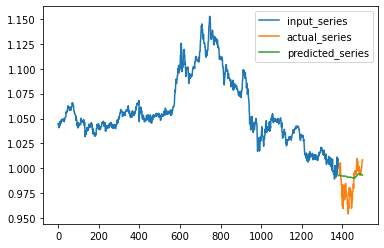

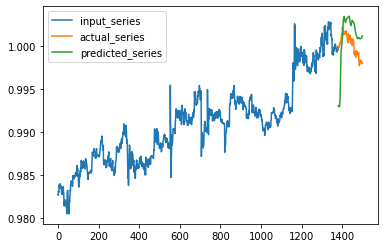

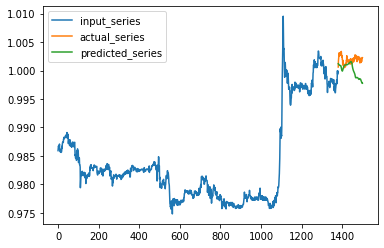

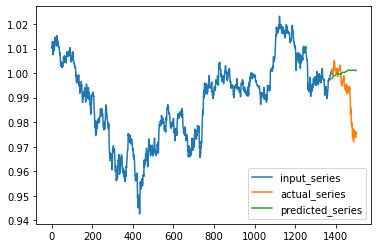

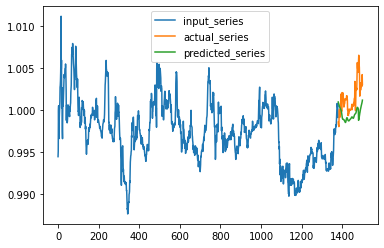

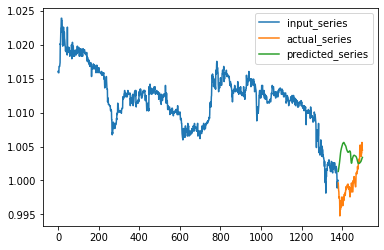

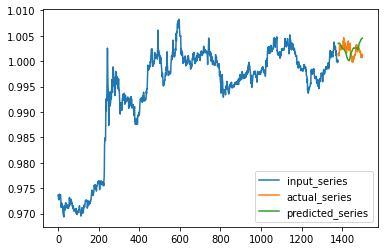

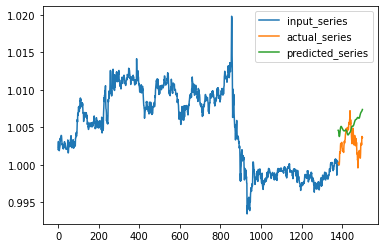

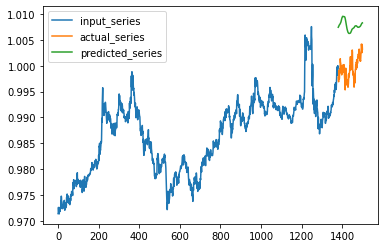

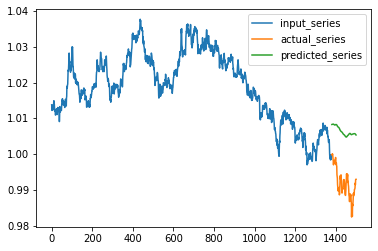

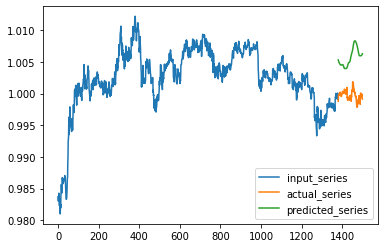

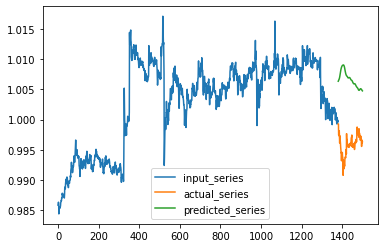

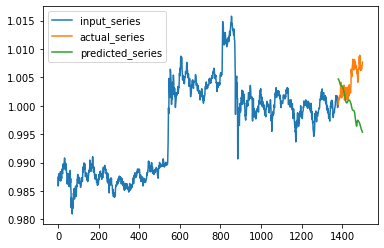

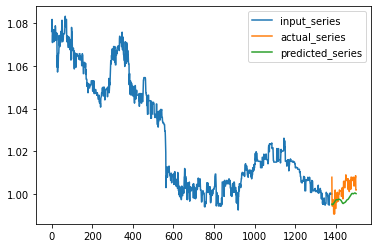

In [35]:
for i in range(20): 
    plt.plot() 
    plot_series(x_train_close[i,:], y_train_close[i,:], predicted_train[i,:])
    plt.show()
